In [1]:
import matplotlib.pyplot as plt
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StructField, StructType, StringType, LongType
import pandas as pd
import numpy as np
import os as os

spark = SparkSession.builder.appName("final").config("spark.sql.caseSensitive", "True").getOrCreate()

In [2]:
os.getcwd()

'c:\\Users\\pchu1\\Desktop'

In [11]:
Iowa = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("VM2Uniform--IA--2021-03-04.tab")


In [16]:
Iowa

DataFrame[SEQUENCE: int, LALVOTERID: string, Voters_Active: string, Voters_StateVoterID: int, Voters_CountyVoterID: string, VoterTelephones_LandlineAreaCode: int, VoterTelephones_Landline7Digit: string, VoterTelephones_LandlineFormatted: string, VoterTelephones_LandlineUnformatted: bigint, VoterTelephones_LandlineConfidenceCode: int, VoterTelephones_CellPhoneOnly: boolean, VoterTelephones_CellPhoneFormatted: string, VoterTelephones_CellPhoneUnformatted: bigint, VoterTelephones_CellConfidenceCode: int, Voters_FirstName: string, Voters_MiddleName: string, Voters_LastName: string, Voters_NameSuffix: string, Residence_Addresses_AddressLine: string, Residence_Addresses_ExtraAddressLine: string, Residence_Addresses_City: string, Residence_Addresses_State: string, Residence_Addresses_Zip: int, Residence_Addresses_ZipPlus4: int, Residence_Addresses_HouseNumber: string, Residence_Addresses_PrefixDirection: string, Residence_Addresses_StreetName: string, Residence_Addresses_Designator: string, R

In [17]:
Iowa = Iowa[['County','Parties_Description', 'CommercialData_EstimatedHHIncome', 'CommercialData_Education','CommercialData_EstimatedAreaMedianHHIncome']]
Iowa = Iowa.toPandas()

In [19]:
CleanUp = {'CommercialData_Education':{
    np.nan: 1, 'Less than HS Diploma - Ex Like': 2, 'Less than HS Diploma - Likely': 3, 
    'HS Diploma - Likely': 4,'HS Diploma - Extremely Likely': 5, 
    'Vocational Technical Degree - Extremely Likely':5,
    'Some College - Likely': 6, 'Some College -Extremely Likely': 7, 
    'Bach Degree - Likely': 8, 'Bach Degree - Extremely Likely': 9, 'Grad Degree - Likely': 10, 
    'Grad Degree - Extremely Likely': 11
},

'CommercialData_EstimatedHHIncome':{
    '$1000-14999': 1, '$15000-24999': 2, '$25000-34999':3, '$35000-49999':4,
    '$50000-74999': 5, '$75000-99999': 6, '$100000-124999': 7, '$125000-149999': 8,
    '$150000-174999': 9, '$175000-199999': 10, '$200000-249999': 11, '$250000+': 12
}

}

Iowa1 = Iowa.replace(CleanUp)

In [6]:
Education = {
    np.nan: 1, 'Less than HS Diploma - Ex Like': 2, 'Less than HS Diploma - Likely': 3, 
    'HS Diploma - Likely': 4,'HS Diploma - Extremely Likely': 5, 
    'Vocational Technical Degree - Extremely Likely':5,
    'Some College - Likely': 6, 'Some College -Extremely Likely': 7, 
    'Bach Degree - Likely': 8, 'Bach Degree - Extremely Likely': 9, 'Grad Degree - Likely': 10, 
    'Grad Degree - Extremely Likely': 11
}

Iowa1 = Iowa.replace({'CommercialData_Education': Education})

In [8]:
Income = {
    '$1000-14999': 1, '$15000-24999': 2, '$25000-34999':3, '$35000-49999':4,
    '$50000-74999': 5, '$75000-99999': 6, '$100000-124999': 7, '$125000-149999': 8,
    '$150000-174999': 9, '$175000-199999': 10, '$200000-249999': 11, '$250000+': 12
}

Iowa1 = Iowa1.replace({'CommercialData_EstimatedHHIncome': Income})

Iowa1['CommercialData_EstimatedHHIncome'].value_counts()

5.0     537521
6.0     484227
7.0     223498
4.0     197715
8.0     173630
3.0      98052
2.0      71276
1.0      62405
12.0     55081
10.0     50952
9.0      47161
11.0     44516
Name: CommercialData_EstimatedHHIncome, dtype: int64

In [25]:
test = Iowa1['CommercialData_EstimatedAreaMedianHHIncome'].unique()
len(test)

2382

In [26]:
Iowa1.columns = ['County', 'Party','Income','Education','AreaIncome']

In [27]:
Iowa1
#Fix AreaIncome, make intervals, try tax brackets

,County,Party,Income,Education,AreaIncome
0,ADAIR,Democratic,5.0,1,$66266
1,ADAIR,Non-Partisan,5.0,1,$66266
2,ADAIR,Non-Partisan,5.0,6,$66266
3,ADAIR,Non-Partisan,2.0,9,$66266
4,ADAIR,Democratic,6.0,4,$69948
...,...,...,...,...,...
2100353,WRIGHT,Democratic,4.0,3,None
2100354,WRIGHT,Republican,4.0,3,None
2100355,WRIGHT,Republican,5.0,11,$73092
2100356,WRIGHT,Republican,5.0,7,$73092


In [87]:
Iowa1.groupby('Education').describe()

Income                                              
              count      mean       std  min  25%  50%  75%   max
Education                                                        
1          577957.0  5.834685  1.762725  1.0  5.0  6.0  6.0  12.0
2             559.0  4.164580  2.181241  1.0  2.0  4.0  5.0  12.0
3           51062.0  5.008402  2.460496  1.0  3.0  5.0  6.0  12.0
4          168284.0  4.936286  2.137880  1.0  4.0  5.0  6.0  12.0
5          290939.0  5.050158  1.965776  1.0  4.0  5.0  6.0  12.0
6          274926.0  6.027542  2.275320  1.0  5.0  6.0  7.0  12.0
7           90633.0  5.564949  2.239559  1.0  4.0  5.0  7.0  12.0
8          123934.0  7.051398  2.532371  1.0  5.0  7.0  8.0  12.0
9          288841.0  6.094131  2.354698  1.0  5.0  6.0  7.0  12.0
10          72911.0  6.645431  2.485348  1.0  5.0  6.0  8.0  12.0
11         105988.0  6.705184  2.530326  1.0  5.0  6.0  8.0  12.0

In [104]:
meanEdu = Iowa1.groupby('Income').mean()
meanInc = Iowa1.groupby('Education').mean()
meanInc,meanEdu

(             Income
 Education          
 1          5.834685
 2          4.164580
 3          5.008402
 4          4.936286
 5          5.050158
 6          6.027542
 7          5.564949
 8          7.051398
 9          6.094131
 10         6.645431
 11         6.705184,
         Education
 Income           
 1.0      5.480971
 2.0      5.455707
 3.0      5.177131
 4.0      5.030291
 5.0      4.606730
 6.0      4.901325
 7.0      5.471168
 8.0      5.842447
 9.0      6.325968
 10.0     6.371762
 11.0     7.024665
 12.0     6.799350)

In [152]:
Iowa3 = Iowa1.groupby('Party', as_index=False).Income.mean()
Iowa4 = Iowa1.groupby('Party',as_index = False).Education.mean()

Iowa3, '\n',Iowa4


(          Party    Income
 0    Democratic  5.650476
 1         Green  5.421392
 2   Libertarian  5.823982
 3  Non-Partisan  5.816028
 4    Republican  6.007867,
 '\n',
           Party  Education
 0    Democratic   5.175242
 1         Green   3.491319
 2   Libertarian   4.044811
 3  Non-Partisan   4.644987
 4    Republican   5.524522)

In [153]:
Iowa5 = Iowa1.groupby('County',as_index=False).Income.mean()
Iowa6 = Iowa1.groupby('County',as_index=False).Education.mean()
print(Iowa5, '\n', Iowa6)

        County    Income
0        ADAIR  5.182106
1        ADAMS  5.340384
2    ALLAMAKEE  5.112249
3    APPANOOSE  4.844646
4      AUDUBON  5.250000
..         ...       ...
94   WINNEBAGO  5.226776
95  WINNESHIEK  5.791563
96    WOODBURY  5.497585
97       WORTH  5.364404
98      WRIGHT  5.211454

[99 rows x 2 columns] 
         County  Education
0        ADAIR   4.936878
1        ADAMS   5.034108
2    ALLAMAKEE   5.128733
3    APPANOOSE   4.851397
4      AUDUBON   5.272220
..         ...        ...
94   WINNEBAGO   5.052589
95  WINNESHIEK   5.258565
96    WOODBURY   4.878074
97       WORTH   5.074143
98      WRIGHT   5.185644

[99 rows x 2 columns]


In [156]:
Iowa7 = Iowa1.groupby(['County','Party']).Income.mean()
Iowa7

County  Party       
ADAIR   Democratic      4.889002
        Green           4.500000
        Libertarian     5.043478
        Non-Partisan    5.297530
        Republican      5.218908
                          ...   
WRIGHT  Democratic      4.915341
        Green           5.666667
        Libertarian     5.230769
        Non-Partisan    5.151057
        Republican      5.402798
Name: Income, Length: 495, dtype: float64

In [157]:
Iowa8 = Iowa1.groupby(['County','Party']).Education.mean()
Iowa7

County  Party       
ADAIR   Democratic      4.889002
        Green           4.500000
        Libertarian     5.043478
        Non-Partisan    5.297530
        Republican      5.218908
                          ...   
WRIGHT  Democratic      4.915341
        Green           5.666667
        Libertarian     5.230769
        Non-Partisan    5.151057
        Republican      5.402798
Name: Income, Length: 495, dtype: float64

In [158]:
Iowa9 = Iowa1.groupby(['County','Party']).describe()
Iowa9

Income                                                 \
                      count      mean       std  min  25%  50%   75%   max   
County Party                                                                 
ADAIR  Democratic     982.0  4.889002  1.910031  1.0  4.0  5.0  6.00  12.0   
       Green            6.0  4.500000  1.760682  1.0  5.0  5.0  5.00   6.0   
       Libertarian     23.0  5.043478  1.551488  1.0  5.0  5.0  5.50   8.0   
       Non-Partisan  1862.0  5.297530  1.857522  1.0  5.0  5.0  6.00  12.0   
       Republican    2179.0  5.218908  1.978834  1.0  4.0  5.0  6.00  12.0   
...                     ...       ...       ...  ...  ...  ...   ...   ...   
WRIGHT Democratic    1760.0  4.915341  1.868683  1.0  4.0  5.0  6.00  12.0   
       Green            9.0  5.666667  2.738613  2.0  5.0  5.0  6.00  12.0   
       Libertarian     26.0  5.230769  1.031802  3.0  5.0  5.0  5.75   8.0   
       Non-Partisan  2317.0  5.151057  1.865412  1.0  5.0  5.0  6.00  12.0   
       Republican    3431.0  5.402798  2.113495  1.0  5.0  5.0  6.00  12.0   

                    Education                                                 
                        count      mean       std  min  25%  50%   75%   max  
County Party                                                                  
ADAIR  Democratic      1034.0  5.219536  2.922882  1.0  4.0  5.0  7.00  11.0  
       Green              6.0  2.333333  2.160247  1.0  1.0  1.0  3.25   6.0  
       Libertarian       23.0  3.434783  2.936078  1.0  1.0  2.0  5.50   9.0  
       Non-Partisan    1914.0  4.525078  2.866000  1.0  1.0  5.0  6.00  11.0  
       Republican      2251.0  5.179476  2.870346  1.0  4.0  5.0  7.00  11.0  
...                       ...       ...       ...  ...  ...  ...   ...   ...  
WRIGHT Democratic      1820.0  5.157143  2.979595  1.0  3.0  5.0  7.00  11.0  
       Green              9.0  4.666667  1.870829  1.0  4.0  5.0  6.00   7.0  
       Libertarian       27.0  4.592593  2.763210  1.0  1.0  6.0  6.00  10.0  
       Non-Partisan    2377.0  4.698780  3.009408  1.0  1.0  5.0  6.00  11.0  
       Republican      3513.0  5.535724  2.984383  1.0  4.0  5.0  8.00  11.0  

[495 rows x 16 columns]

<AxesSubplot:xlabel='Party'>

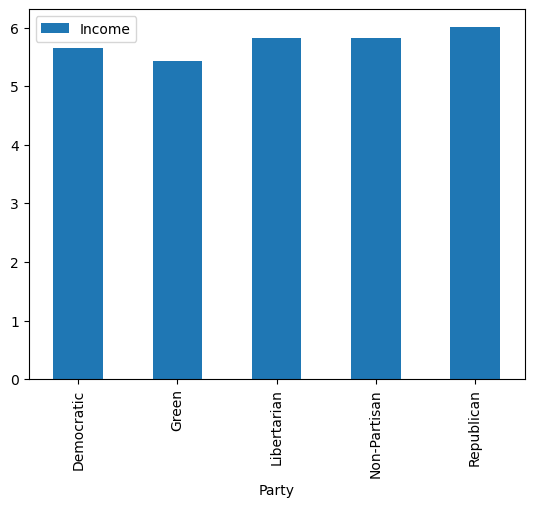

In [163]:
Iowa3.plot(x = 'Party', y = 'Income', kind = 'bar')

<AxesSubplot:xlabel='Party'>

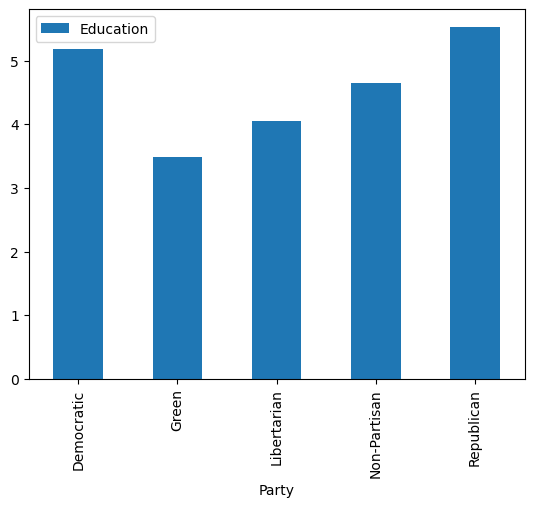

In [162]:
Iowa4.plot(x = 'Party', y = 'Education', kind = 'bar')

In [ ]:
# Start with how does edu, income, land look as a whole on state, look at edu income, land on top 5 vs bottom 5, how did the people vote? 
# what kind of conclusions? Run regression, conclusion
#Copy paste to next state